<a href="https://colab.research.google.com/github/ramon-m-machado/training-notes/blob/main/SimpleDLFapesp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

# ler e processar imagens
import imageio.v2 as iio
from PIL import Image
import cv2 as cv

# para acessar as imagens no diretorio
import os

# regex para extrair a classe do nome do arquivo
import re

In [5]:
# imports para o k fold
from sklearn.model_selection import StratifiedKFold # Cross Validation Function.
# like top_k_categorical_accuracy but for labels integer-encoded
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

from sklearn import metrics

In [6]:
# imports data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [7]:
#imports spiderplot
import plotly.graph_objects as go

import pandas as pd

In [8]:
# import confusion matrix
from plotly.subplots import make_subplots

from matplotlib.colors import LinearSegmentedColormap

In [9]:
# imports para as metricas
from sklearn.metrics import classification_report

### Tamanho da imagem

In [10]:
size = 250
border = 150

### Ler imagens

In [11]:
base_path = '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/'
path = [base_path + 'Control/', base_path + 'Serial/', base_path + 'Streak/']
trainingImages = []
labels = []
for i in range(3):
    for file in os.listdir(path[i]):
        img = np.array(Image.open(path[i]+file).convert('L'))
        imgCut = img[border:-border,border:-border]
        imgResize = cv.resize(imgCut, dsize = (size,size))
        trainingImages.append(imgResize)

        a = re.search(r"\d-\d*_.M_P1C(\d+)", file)
        labels.append(a.groups()[0])

In [12]:
labels = np.array(labels, dtype=np.int8) -1

In [13]:
trainingImages = np.array(trainingImages)

### Data Augmentation

In [14]:
dataAugmentation = tf.keras.models.Sequential([

  tf.keras.layers.RandomRotation(factor=0.05,fill_mode='nearest', input_shape=(size,size,1)),

  tf.keras.layers.RandomZoom(0.05)]
)

###Modelo

In [15]:
def simple_dl():
  model = tf.keras.models.Sequential()

  model.add(dataAugmentation)
  model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D((2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  return model

###Metricas

In [16]:
def top_2k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_3k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5k_accuracy(y_true,y_pred):
  return sparse_top_k_categorical_accuracy(y_true, y_pred, k=5)

def true_positive(y_true, y_pred):
  return tf.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32), axis=0)


In [17]:
metrics = ['accuracy', top_2k_accuracy, top_3k_accuracy, top_5k_accuracy]
#tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

###Salvar modelo

In [18]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/FAPESP/model.ckpt"

# callback para salvar os pesos do modelo
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

### K fold

In [19]:
n_split = 5

skf = StratifiedKFold(n_splits=n_split, random_state=42, shuffle=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [20]:
k = 0
loss = np.empty((n_split))
accuracys = np.empty((n_split))
top_2k = np.empty((n_split))
top_3k = np.empty((n_split))
top_5k = np.empty((n_split))
tp = np.empty((n_split))
cf_matrix = np.empty((n_split,10,10)) # matriz de confusao para cada k
y_pred_all = []
labels_test_all = []
y_pred_prob = []

for (train_index, test_index) in skf.split(trainingImages, labels):

  model = simple_dl()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= metrics)

  print(f'\n\n\t FOLD: {k+1}/{n_split}', end="\n\n")

  model.fit(trainingImages[train_index],
            labels[train_index], epochs=80,
            validation_data=(trainingImages[test_index], labels[test_index]),
            callbacks=[callback, cp_callback],
            batch_size=64,
            verbose=False)

  loss[k], accuracys[k], top_2k[k], top_3k[k], top_5k[k] = model.evaluate(trainingImages[test_index], labels[test_index])

  # probabilities
  y_pred =  model.predict(trainingImages[test_index])
  # todas probabilidades
  y_pred_prob.append(y_pred)
  # predicted class
  y_pred_labels = np.argmax(y_pred, axis=1)

  # salvar as predicoes e o esperado para cada k, para o 'classification_report'
  y_pred_all.append(y_pred_labels)
  labels_test_all.append(labels[test_index])

  tp[k] = true_positive(labels[test_index], y_pred_labels).numpy()

  cf_matrix[k] = tf.math.confusion_matrix(
                labels[test_index],
                y_pred_labels,
                num_classes=None,
                weights=None,
                dtype=float,
                name=None
              )
  k+=1



	 FOLD: 1/5

2/2 [==============================] - 0s 7ms/step


	 FOLD: 2/5

2/2 [==============================] - 0s 7ms/step


	 FOLD: 3/5

2/2 [==============================] - 0s 6ms/step


	 FOLD: 4/5

2/2 [==============================] - 0s 9ms/step


	 FOLD: 5/5

2/2 [==============================] - 0s 16ms/step - loss: 1.6237 - accuracy: 0.7750 - top_2k_accuracy: 0.8250 - top_3k_accuracy: 0.8750 - top_5k_accuracy: 0.9000


2/2 [==============================] - 0s 7ms/step


In [21]:
cf_geral = np.zeros((10,10))
for i in range(n_split):
  cf_geral += np.array(cf_matrix[i])

In [22]:
print('Cross-Validation Metrics\n')
print('Accuracy: %.3f +/- %.3f' %(np.mean(accuracys), np.std(accuracys)))
print('Loss:     %.3f +/- %.3f' %(np.mean(loss), np.std(loss)))
print('Top 2k:   %.3f +/- %.3f' %(np.mean(top_2k), np.std(top_2k)))
print('Top 3k:   %.3f +/- %.3f' %(np.mean(top_3k), np.std(top_3k)))
print('Top 5k:   %.3f +/- %.3f' %(np.mean(top_5k), np.std(top_5k)))

Cross-Validation Metrics

Accuracy: 0.830 +/- 0.043
Loss:     1.084 +/- 0.298
Top 2k:   0.870 +/- 0.029
Top 3k:   0.890 +/- 0.025
Top 5k:   0.930 +/- 0.029


### Matriz de confusao

In [23]:
classes = ["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]

In [24]:
colors = ["#005F73","#0A9396","#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226"]
cmap = LinearSegmentedColormap.from_list("", colors)


#### Matriz para cada k-fold

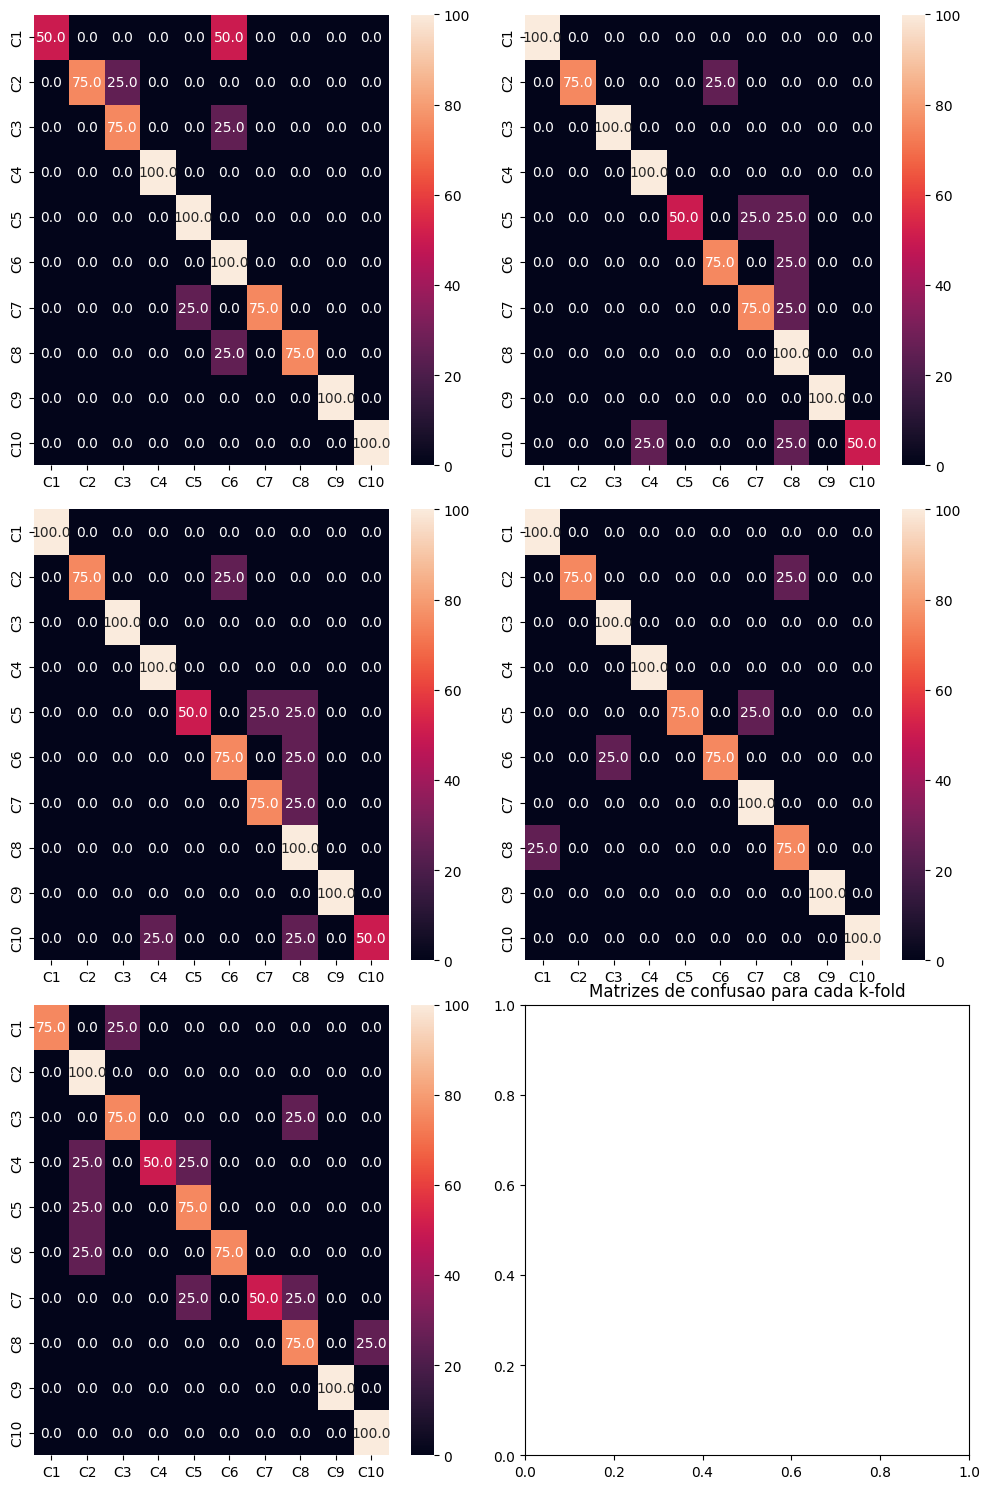

In [25]:
# subplot com 3 linhas e 2 colunas cada (uso 5)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# plotar as 4 matrizes de confusao dos 4 primeiros folds
for i in range(2):
  for j in range(2):
    sn.heatmap(cf_matrix[i+j]*100 / np.max(cf_matrix[i+j]),
      annot=True, fmt=".1f",
      annot_kws={"size": 10},
      xticklabels=classes,
      yticklabels=classes,
      #cmap=cmap,
      ax=axs[i,j])

# plotar a matriz de confusao do ultimo fold
sn.heatmap(cf_matrix[4]*100 / np.max(cf_matrix[4]),
  annot=True, fmt=".1f",
  annot_kws={"size": 10},
  xticklabels=classes,
  yticklabels=classes, ax=axs[2,0])

# Ajustar espaco
plt.tight_layout()
plt.title("Matrizes de confusao para cada k-fold")
plt.show()

#### Matriz geral

In [26]:
colors_error = ["#94D2BD","#E9D8A6","#EE9B00","#CA6702","#BB3E03","#AE2012","#9B2226","#005F73"]
cmap_error = LinearSegmentedColormap.from_list("", colors_error)

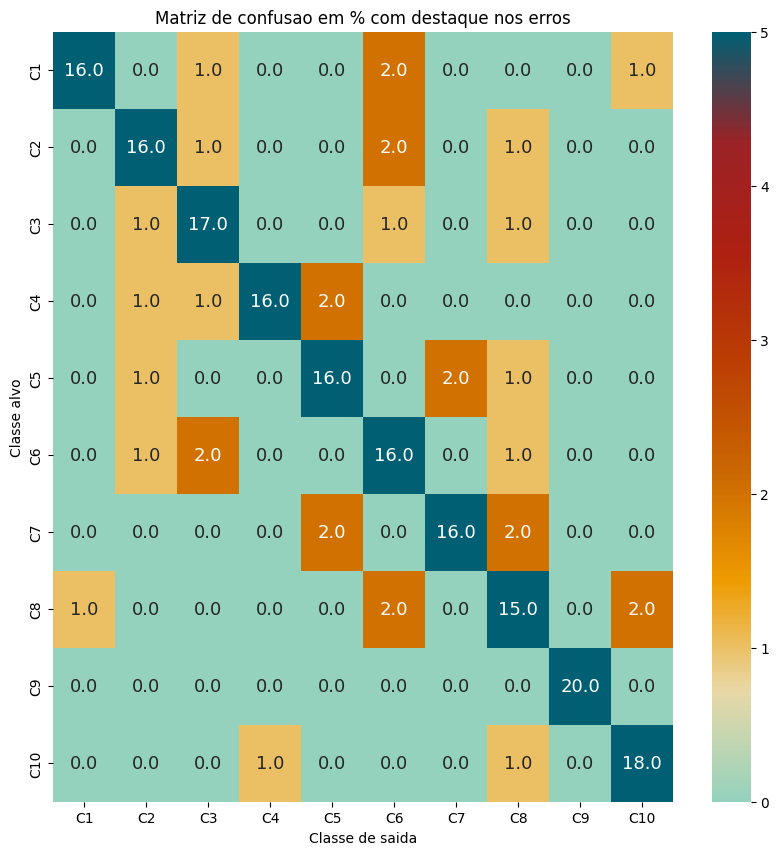

In [27]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_geral,
           annot=True,
           fmt="",
           annot_kws={"size": 13},
           xticklabels=classes,
           yticklabels=classes,
           cmap=cmap_error,
           vmin=0,
           vmax=5)

plt.title("Matriz de confusao em % com destaque nos erros")
plt.xlabel("Classe de saida")
plt.ylabel("Classe alvo")

plt.show()

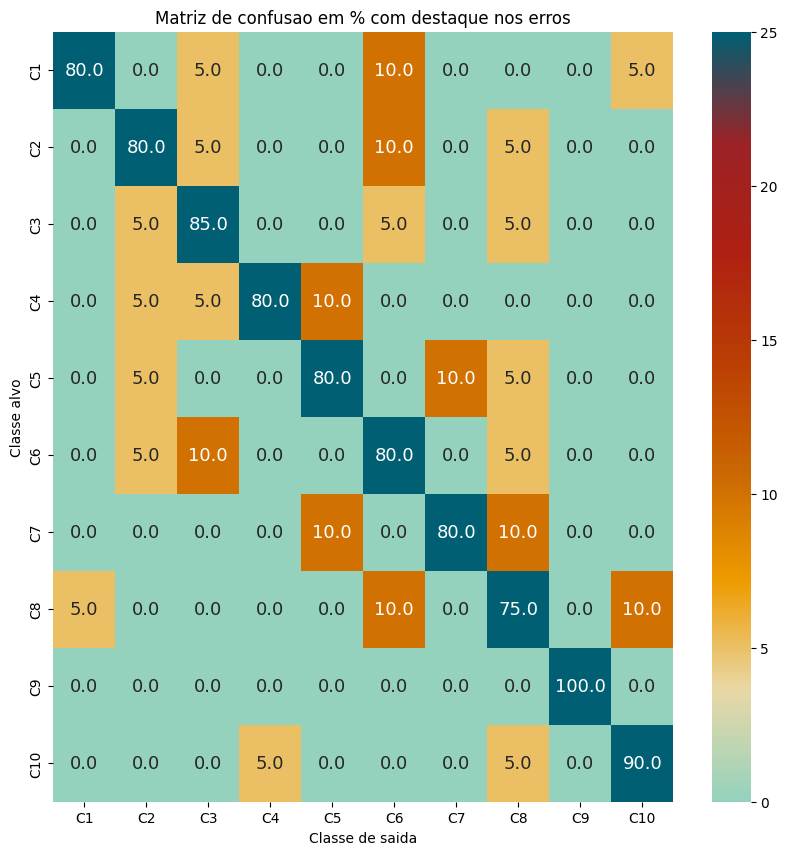

In [28]:
plt.figure(figsize=(10,10))
sn.heatmap(cf_geral*100/20,
           annot=True,
           fmt=".1f",
           annot_kws={"size": 13},
           xticklabels=classes,
           yticklabels=classes,
           cmap=cmap_error,
           vmin=0,
           vmax=25)

plt.title("Matriz de confusao em % com destaque nos erros")
plt.xlabel("Classe de saida")
plt.ylabel("Classe alvo")

plt.show()

### Extraindo metricas da matriz

In [29]:
def printar_metrica(nome, metrica, metrica_porcentagem = None):
  df = pd.DataFrame({'classe': classes,
                      nome: metrica})

  if metrica_porcentagem is not None:
    df = pd.DataFrame({'classe': classes,
                        nome: metrica,
                        str(nome + "%"): metrica_porcentagem,})

  return df

In [30]:
cf_percent = cf_geral*100 / 20

####Falsos positivos (FP)
* Classificados como essa classe, mas eram de outra;
* Soma de cada coluna excluindo a diagonal principal.

In [31]:
FP = cf_geral.sum(axis=0) - np.diag(cf_geral)
FP_percent = np.round(cf_percent.sum(axis=0) - np.diag(cf_percent),2)

FP_table = printar_metrica("FP", FP, FP_percent)
FP_table.head(10)

,classe,FP,FP%
0,C1,1.0,5.0
1,C2,4.0,20.0
2,C3,5.0,25.0
3,C4,1.0,5.0
4,C5,4.0,20.0
5,C6,7.0,35.0
6,C7,2.0,10.0
7,C8,7.0,35.0
8,C9,0.0,0.0
9,C10,3.0,15.0


#### Falsos negativos (FN)
* Classificados como essa classe, mas eram de outra;
* Soma de cada linha excluindo a diagonal principal.

In [32]:
FN = cf_geral.sum(axis=1) - np.diag(cf_geral)
FN_percent = np.round(cf_percent.sum(axis=1) - np.diag(cf_percent),2)

FN_table = printar_metrica("FN", FN, FN_percent)
FN_table.head(10)

,classe,FN,FN%
0,C1,4.0,20.0
1,C2,4.0,20.0
2,C3,3.0,15.0
3,C4,4.0,20.0
4,C5,4.0,20.0
5,C6,4.0,20.0
6,C7,4.0,20.0
7,C8,5.0,25.0
8,C9,0.0,0.0
9,C10,2.0,10.0


####Verdadeiros Positivos (TP)
* acurácia para cada classe

In [33]:
TP = np.diag(cf_geral)
TP_percent = np.round(np.diag(cf_percent),2)

TP_table = printar_metrica("TP", TP, TP_percent)
TP_table.head(10)

,classe,TP,TP%
0,C1,16.0,80.0
1,C2,16.0,80.0
2,C3,17.0,85.0
3,C4,16.0,80.0
4,C5,16.0,80.0
5,C6,16.0,80.0
6,C7,16.0,80.0
7,C8,15.0,75.0
8,C9,20.0,100.0
9,C10,18.0,90.0


#### Verdadeiros Negativos (TN):
 * Instâncias das outras classes preditas como outras classes.
 * Erros não importam desde que a classe em questão não esteja envolvida

In [34]:
TN = cf_geral.sum() - (FP + FN + TP)

TN_table = printar_metrica("TN", TN)
TN_table.head(10)

,classe,TN
0,C1,179.0
1,C2,176.0
2,C3,175.0
3,C4,179.0
4,C5,176.0
5,C6,173.0
6,C7,178.0
7,C8,173.0
8,C9,180.0
9,C10,177.0


#### Sensitividade

sensitividade mede a proporção de positivos do total (acurácia?)

In [35]:
sensitividade = TP/(TP+FN)

sensitividade_table = printar_metrica("Sensitividade", sensitividade*100)
sensitividade_table.head(10)

,classe,Sensitividade
0,C1,80.0
1,C2,80.0
2,C3,85.0
3,C4,80.0
4,C5,80.0
5,C6,80.0
6,C7,80.0
7,C8,75.0
8,C9,100.0
9,C10,90.0


#### Especificidade

Quantifica a proporção de TN classificados corretamente, pode ser vista como a tava de TN (TNR)

In [36]:
especificidade = TN/(TN+FP)

especificidade_table = printar_metrica("Especificidade", np.round(especificidade,3))
especificidade_table.head(10)

,classe,Especificidade
0,C1,0.994
1,C2,0.978
2,C3,0.972
3,C4,0.994
4,C5,0.978
5,C6,0.961
6,C7,0.989
7,C8,0.961
8,C9,1.000
9,C10,0.983


#### Precisão

In [37]:
precisao = TP/(TP+FP)

precisao_table = printar_metrica("Precisao", np.round(precisao,3))
precisao_table.head(10)

,classe,Precisao
0,C1,0.941
1,C2,0.800
2,C3,0.773
3,C4,0.941
4,C5,0.800
5,C6,0.696
6,C7,0.889
7,C8,0.682
8,C9,1.000
9,C10,0.857


#### F1 Score

In [38]:
recall = sensitividade
F1_score = 2* (precisao*recall/(precisao + recall))

F1_table = printar_metrica("F1", np.round(F1_score,3))
F1_table.head(10)

,classe,F1
0,C1,0.865
1,C2,0.800
2,C3,0.810
3,C4,0.865
4,C5,0.800
5,C6,0.744
6,C7,0.842
7,C8,0.714
8,C9,1.000
9,C10,0.878


##### F1 Score Macro
* media dos F1 Scores

In [39]:
F1_macro = np.mean(F1_score)
round(F1_macro,3)

0.832

##### F1 Score Micro

* Computa um F1 medio global, somando todos os TP, FN e FP e colocando na formula do F1

In [40]:
sum_recall = np.sum(recall)
sum_precisao = np.sum(precisao)

#F1_micro = 2 * (np.sum(recall)*np.sum(precisao) / (np.sum(recall)+np.sum(precisao)))/10
F1_micro = np.sum(TP)/(np.sum(TP)+ (0.5*(np.sum(FP)+np.sum(FN))))
round(F1_micro,3)

0.83

###Comparar resultados

In [41]:
labels_test_all2 = np.array(labels_test_all).flatten()
labels_test_all2.shape

(200,)

In [42]:
y_pred_all2 = np.array(y_pred_all).flatten()
y_pred_all2.shape

(200,)

In [43]:
np.unique(y_pred_all2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
dict_metrics = classification_report(y_pred_all2, labels_test_all2,labels = np.unique(y_pred_all2), target_names=classes, output_dict=True)

In [45]:
dict_metrics["C2"]

{'precision': 0.8,
 'recall': 0.8,
 'f1-score': 0.8000000000000002,
 'support': 20}

In [46]:
F1_score[1]

0.8000000000000002

In [47]:
precisao

array([0.94117647, 0.8       , 0.77272727, 0.94117647, 0.8       ,
       0.69565217, 0.88888889, 0.68181818, 1.        , 0.85714286])

In [48]:
precisao_c1 = TP[0]/(TP[0]+FP[0])
recall_c1 = TP[0]/(TP[0]+FN[0])

f1_c1 = 2*(precisao_c1*recall_c1/(precisao_c1+recall_c1))
f1_c1

0.8648648648648648

In [49]:
precisao_c1

0.9411764705882353

In [50]:
especificidade

array([0.99444444, 0.97777778, 0.97222222, 0.99444444, 0.97777778,
       0.96111111, 0.98888889, 0.96111111, 1.        , 0.98333333])

###Spider-Plot

In [51]:
df_metricas = pd.DataFrame(dict(
    porcentagem=[
       np.mean(accuracys)*100,
       np.mean(top_2k)*100,
       np.mean(top_3k)*100,
       np.mean(top_5k)*100,
       np.mean(sensitividade)*100,
       np.mean(especificidade)*100,
       np.mean(F1_micro)*100,
       np.mean(F1_macro)*100],
    metricas=['Accuracy','Top 2k','Top 3k','Top 5k','Sensitividade','Especificidade','F1 Micro', 'F1 Macro']))

fig = go.Figure()

fig = fig.add_trace(go.Scatterpolar(
        name = "Metricas",
        r = df_metricas['porcentagem'],
        theta = df_metricas['metricas'],

    ))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,)),
                  showlegend=True,
                  title='Métricas em Porcentagem',
                  titlefont={'size': 28, 'family':'Serif'},
                  template='plotly_dark',
                  paper_bgcolor='gray',
                  width=600, height=500,
                  font=dict(
                  size=15,
                 ))
fig.update_traces(fill='toself')
fig.show()

###Histograma de probabilidade Geral

mostra a quantidade de imagens que foram classificadas com determinada certeza.

In [52]:
# prever uma unica imagem
model.predict(np.array([trainingImages[0]]))

1/1 [==============================] - 0s 200ms/step


array([[9.5696270e-01, 1.1409235e-02, 1.8222718e-02, 3.6250865e-03,
        1.0172513e-06, 6.2111947e-03, 4.5030715e-10, 3.5611843e-03,
        1.1751279e-08, 6.8861236e-06]], dtype=float32)

In [53]:
proba = []
true_class = [] # pegar a classe verdadeira
pred_class = [] # pegar a classe predita
for (train_index, test_index) in skf.split(trainingImages, labels):
  predicted = model.predict(np.array(trainingImages[test_index])) #pegar prob das imagens de teste desse fold
  proba.append(predicted)
  pred_class.append(np.argmax(predicted, axis=1))
  true_class.append(labels[test_index])

2/2 [==============================] - 0s 6ms/step


In [54]:
#pegar as imagens de teste de cada fold e ver as probabilidades
labels_test_all = np.array(labels_test_all) # true labels
y_pred_prob = np.array(y_pred_prob) # probabilities for all test images
y_pred_all = np.array(y_pred_all) # labels pred

In [55]:
max_proba = np.max(y_pred_prob, axis = 2).flatten()

Text(0, 0.5, 'Quantidade de imagens')

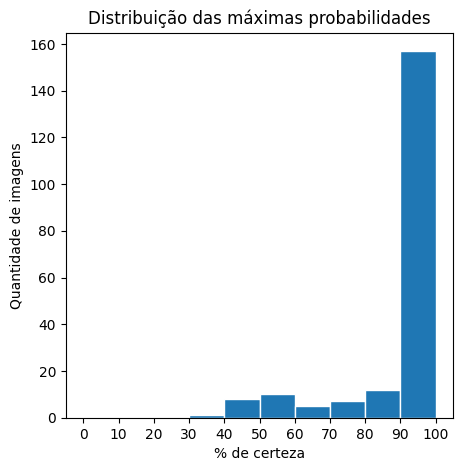

In [56]:
plt.rcParams["figure.figsize"] = [5, 5]
bins=np.arange(0, 101, 10)
plt.hist(max_proba * 100, bins=bins, edgecolor='w')
plt.xticks(bins);
plt.title("Distribuição das máximas probabilidades")
plt.xlabel("% de certeza")
plt.ylabel("Quantidade de imagens")

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_all.flatten(), labels_test_all.flatten())

0.83

### Recuperação de imagens

In [58]:
def plot_images(N, images, labels_pred, labels_true):
  # plotar as imagens, de N em N
  n_rows = images.shape[0]//N if images.shape[0] % N == 0 else images.shape[0]//N + 1
  n_columns = N

  plt.rcParams["figure.figsize"] = [20, n_rows*5]
  plt.rcParams["figure.autolayout"] = True
  plt.subplot()

  for i in range(images.shape[0]):
    plt.subplot(n_rows, n_columns, i+1);
    plt.imshow(images[i], cmap="gray");
    plt.title(f"C{labels_pred[i]} era C{labels_true[i]}")

In [88]:
# imagens que errou a classificação
img_pred_wrong = trainingImages[labels_test_all.flatten() != y_pred_all.flatten()]
print(f"Errou {img_pred_wrong.shape[0]} imagens")

Errou 34 imagens


In [89]:
labels_pred = y_pred_all[labels_test_all != y_pred_all].flatten()
labels_true = labels_test_all[labels_test_all != y_pred_all].flatten()

<ipython-input-58-cfdcd139de4e>:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



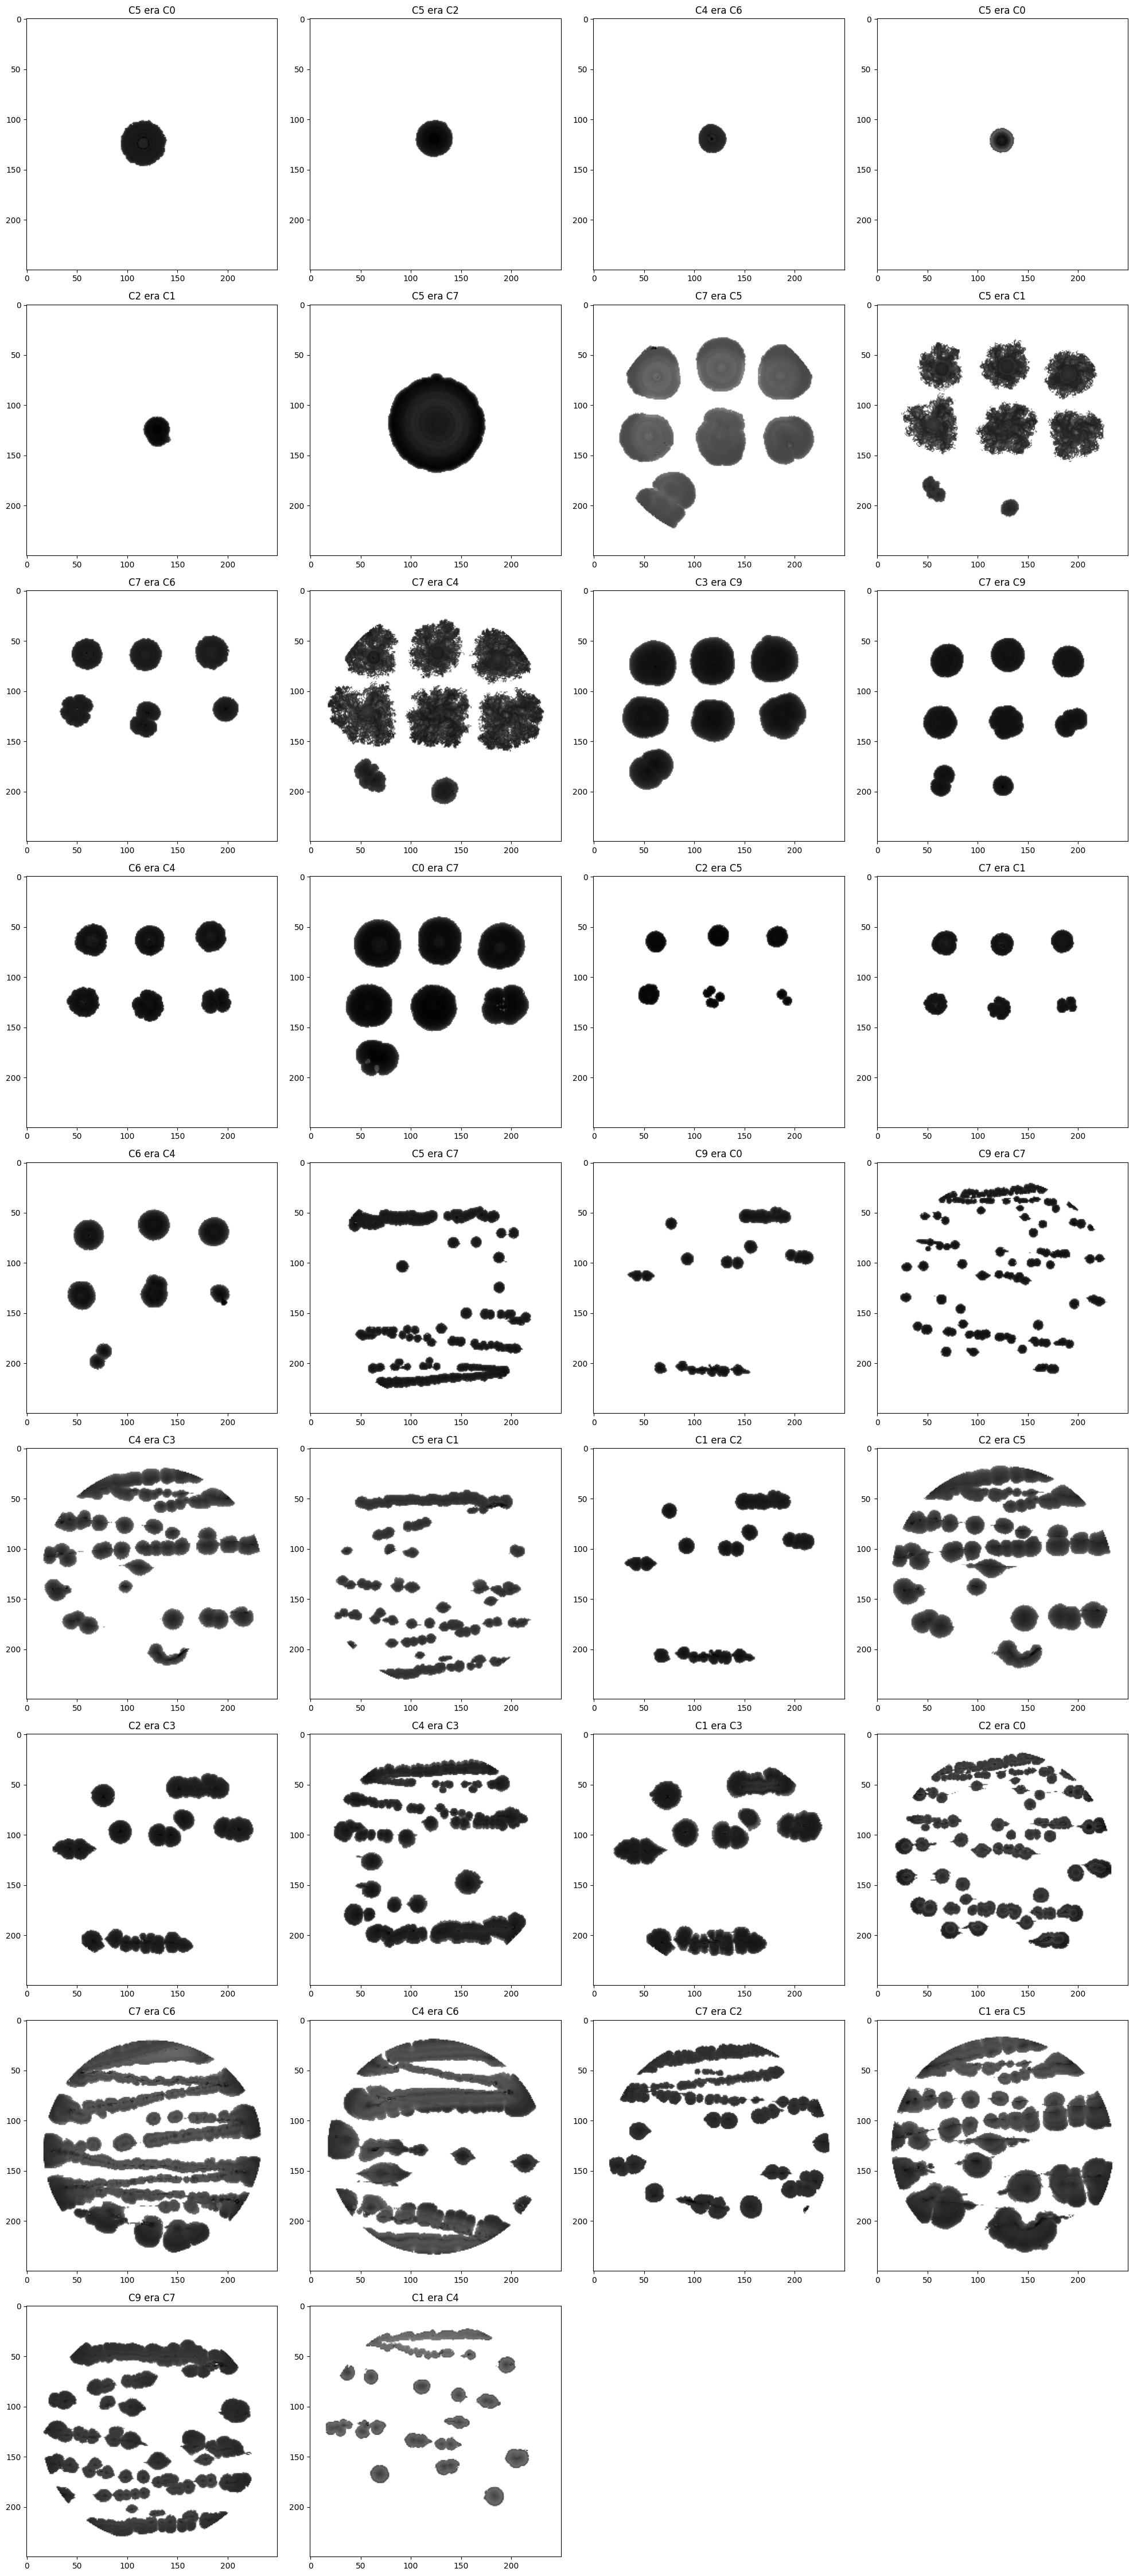

In [90]:
plot_images(4, img_pred_wrong, labels_pred, labels_true)

#### Imagens em que teve mais dúvida

In [91]:
# teve mais dúvida (menos de "proba"% de probabilidade de ser da classe alvo segundo o modelo)
proba = 0.5
index_of_proba = max_proba < proba
img_duvida = trainingImages[max_proba < 0.5]
print(f"Duvida em {img_duvida.shape[0]} imagens")

Duvida em 9 imagens


In [92]:
labels_pred = y_pred_all.flatten()[index_of_proba]
labels_true = labels_test_all.flatten()[index_of_proba]

In [93]:
print(labels_pred)
print(labels_true)

[5 8 8 0 9 9 4 5 8]
[2 8 8 7 0 7 4 1 8]


In [106]:
print(f'Acurácia entre as que teve dúvida {round(accuracy_score(labels_true, labels_pred),2)*100}%')

Acurácia entre as que teve dúvida 44.0%


<ipython-input-58-cfdcd139de4e>:11: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



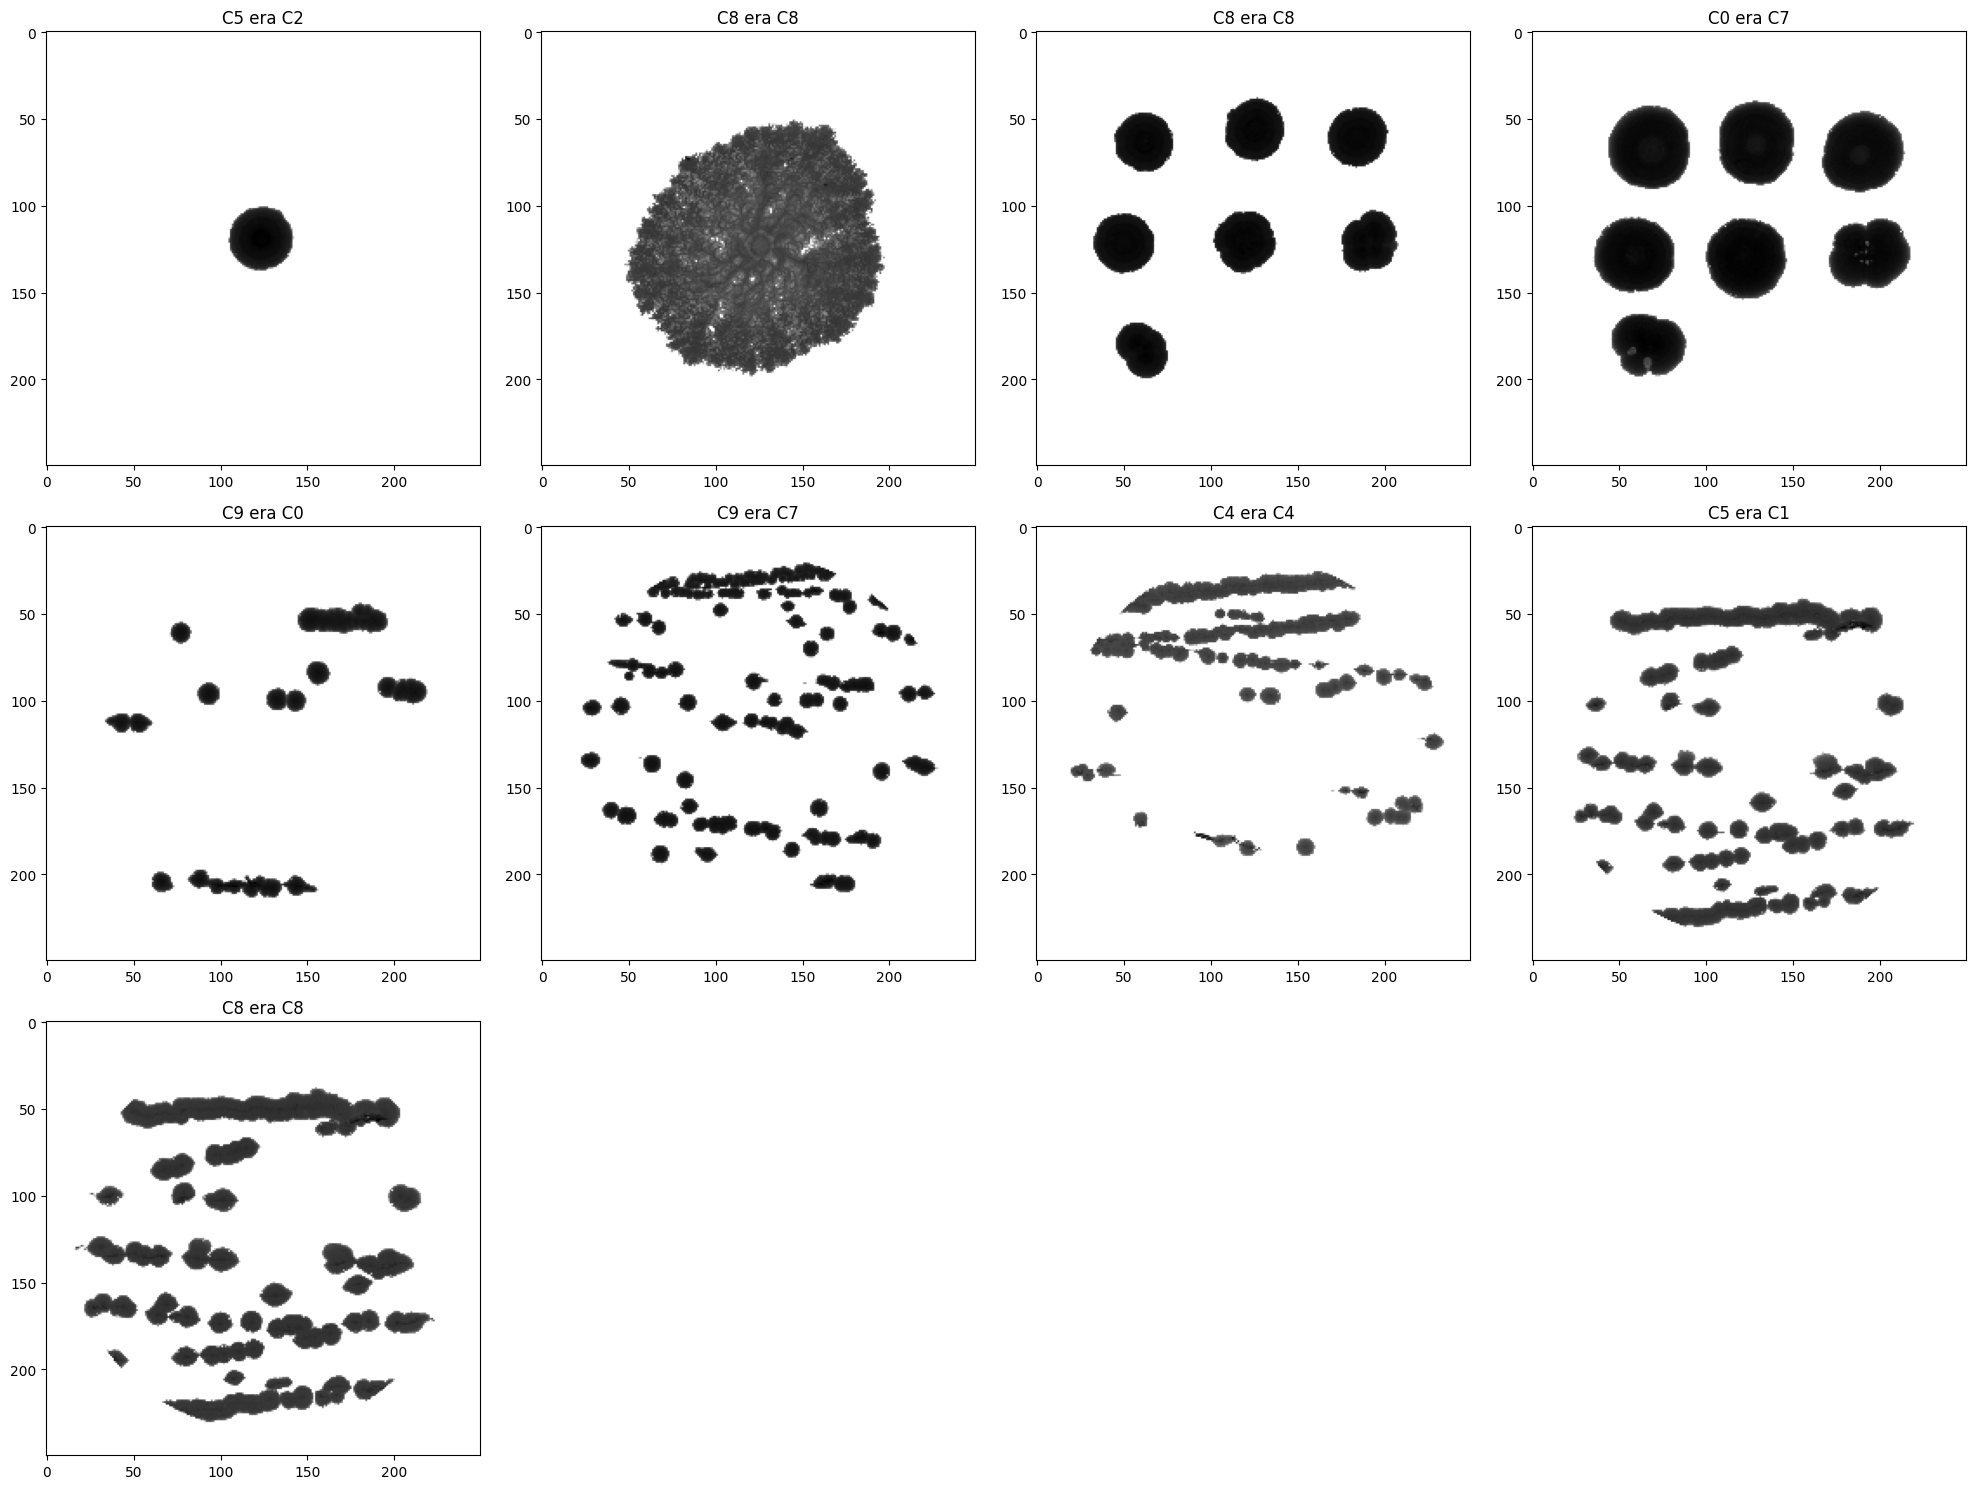

In [95]:
plot_images(4, img_duvida, labels_pred, labels_true)

###Histogramas por classe

In [96]:
labels_test_all = np.array(labels_test_all) # true labels
y_pred_prob = np.array(y_pred_prob) # probabilities for all test images
y_pred_all = np.array(y_pred_all) # labels pred

In [97]:
plt.rcParams["figure.figsize"] = [5, 5]

In [98]:
y_pred_prob.shape

(5, 40, 10)

In [99]:
max_proba.shape

(200,)

In [100]:
y_pred.shape

(40, 10)

[  0  10  20  30  40  50  60  70  80  90 100]


<ipython-input-102-605c5ea2592b>:15: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



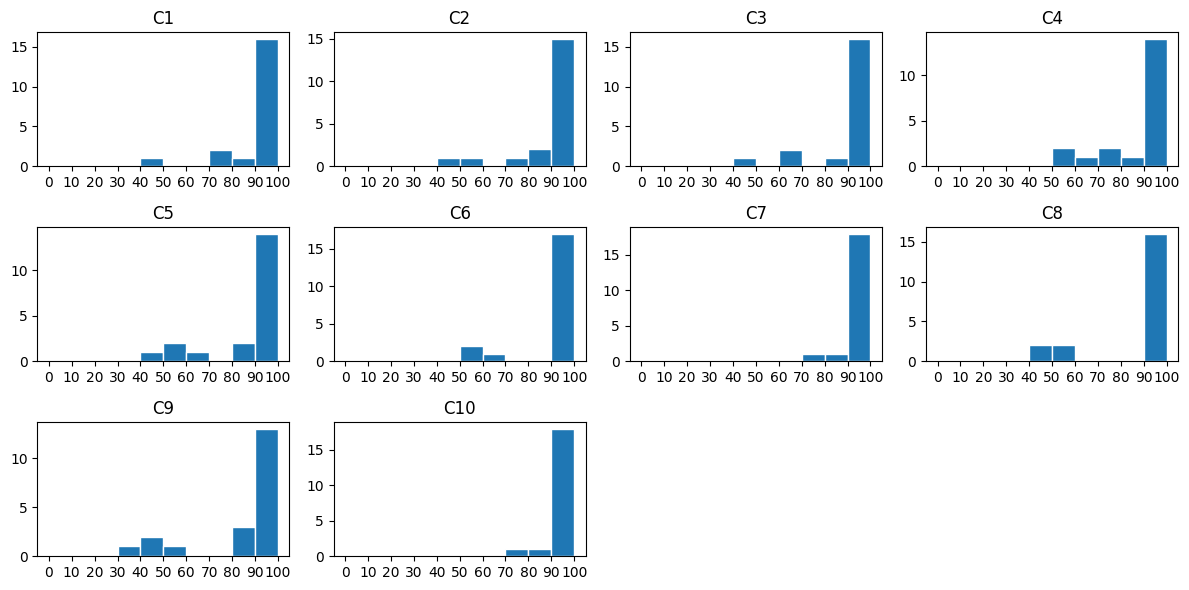

In [102]:
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.autolayout"] = True
plt.subplot()

y_true = labels_test_all.flatten()
y_pred = y_pred_prob.flatten()*100
class_histogram = np.zeros((10,10))

bins=np.arange(0, 101, 10)
print(bins)
for i in range(10):
  indexes_class = np.where(y_true == i)[0]
  # np.digitize(y_pred[indexes_class],bins)
  # class_histogram
  plt.subplot(3, 4, i+1)
  plt.hist(max_proba[indexes_class]*100,  bins=bins, edgecolor='w');
  plt.xticks(bins);
  plt.title(f"C{i+1}")

### Leave one out

In [ ]:
# equivalete a KFold(n_splits=n)

In [108]:
from sklearn.model_selection import LeaveOneOut

In [124]:
cv = LeaveOneOut()
i = 0
for a, b in cv.split(trainingImages):
  print(a.shape, b.shape)
  print("label",labels[b])
  i += 1
  if i > 5:
    break

(199,) (1,)
label [0]
(199,) (1,)
label [3]
(199,) (1,)
label [3]
(199,) (1,)
label [8]
(199,) (1,)
label [5]
(199,) (1,)
label [2]


In [137]:
n = 200

y_pred = []

cv = LeaveOneOut()
k = 0
for train_ix, test_ix in cv.split(trainingImages):

  X_train, X_test = trainingImages[train_ix, :], trainingImages[test_ix, :]
  y_train, y_test = labels[train_ix], labels[test_ix]

  model = simple_dl()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

  model.fit(X_train,
            y_train,
            epochs=80,
            callbacks=[callback, cp_callback],
            batch_size=64,
            verbose=False)

  y_pred.append(model.predict(X_test)[0])
  k += 1
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

1/1 [==============================] - 0s 92ms/step


ValueError: ignored

In [138]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [139]:
acc = accuracy_score(labels, y_pred_labels)
print('Accuracy: %.3f' % acc)

Accuracy: 0.690


### SHAP

In [ ]:
pip install shap

In [ ]:
import shap

ver o problema do input shape (espera que seja uma imagem 3d)
* procurar se tem alguma implementada para 2d;
* testar se adicionar mais uma dimensao com 0 faz efeito;
* usar as imagens 3d para treinar o modelo;
* ver se e possivel modificar a funcao da biblioteca para rodar em 2d

In [ ]:
# select a set of background examples to take an expectation over
background = trainingImages[np.random.choice(trainingImages.shape[0], 20, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(trainingImages[0:3])

# plot the feature attributions
shap.image_plot(shap_values, -trainingImages[0:3])

### LIME

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html

In [ ]:
pip install lime

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
plt.rcParams["figure.figsize"] = [5,5]
plt.imshow(trainingImages[max_proba < 0.5][0], cmap="gray")

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
# image -> image to be explained
# predict_fn -> probabilidades
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)